This notebook contains python code I used to do a linear regression model. I am using a data set called "Energy efficiency Data Set" which is obtained from https://archive.ics.uci.edu/ml/datasets/Energy+efficiency .

## Some basic Info about the data set:

Attribute Information:

The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses. 

Specifically: 

- X1	Relative Compactness 
- X2	Surface Area - m²
- X3	Wall Area - m²
- X4	Roof Area  - m²
- X5	Overall Height - m
- X6	Orientation 2:North, 3:East, 4:South, 5:West
- X7	Glazing Area 0%, 10%, 25%, 40% (of floor area)
- X8	Glazing Area Distribution 1:Uniform, 2:North, 3:East, 4:South, 5:West
- y1	Heating Load kWh/m²
- y2	Cooling Load kWh/m²

### First I import the modules needed.

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from pandas.api.types import CategoricalDtype
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

In [7]:
df = pd.read_excel('Energy.xlsx')

In [8]:
df.shape

(768, 10)

We see that the data has 768 observations and 10 variables (columns).

In [9]:
df.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2'], dtype='object')

Based on the Attribute Information, I notice that some variables should be categorical
variables. For instance, 'X6' which represents orientation. Now I am going to look at
what are different values of this attribute by using 'unique' command. I do similar
stuff with 'X8' and 'X7' since they look categorical as well.

In [13]:
df['X8'].unique()

array([0, 1, 2, 3, 4, 5])

In [14]:
df['X7'].unique()

array([0.  , 0.1 , 0.25, 0.4 ])

In [15]:
df['X6'].unique()

array([2, 3, 4, 5])

In [16]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


Let's look at some basic statitics for each attribute.

In [17]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


I am also doing some scatter plots to explore relationship between variables also it 
will show me the distribution of each attribute.

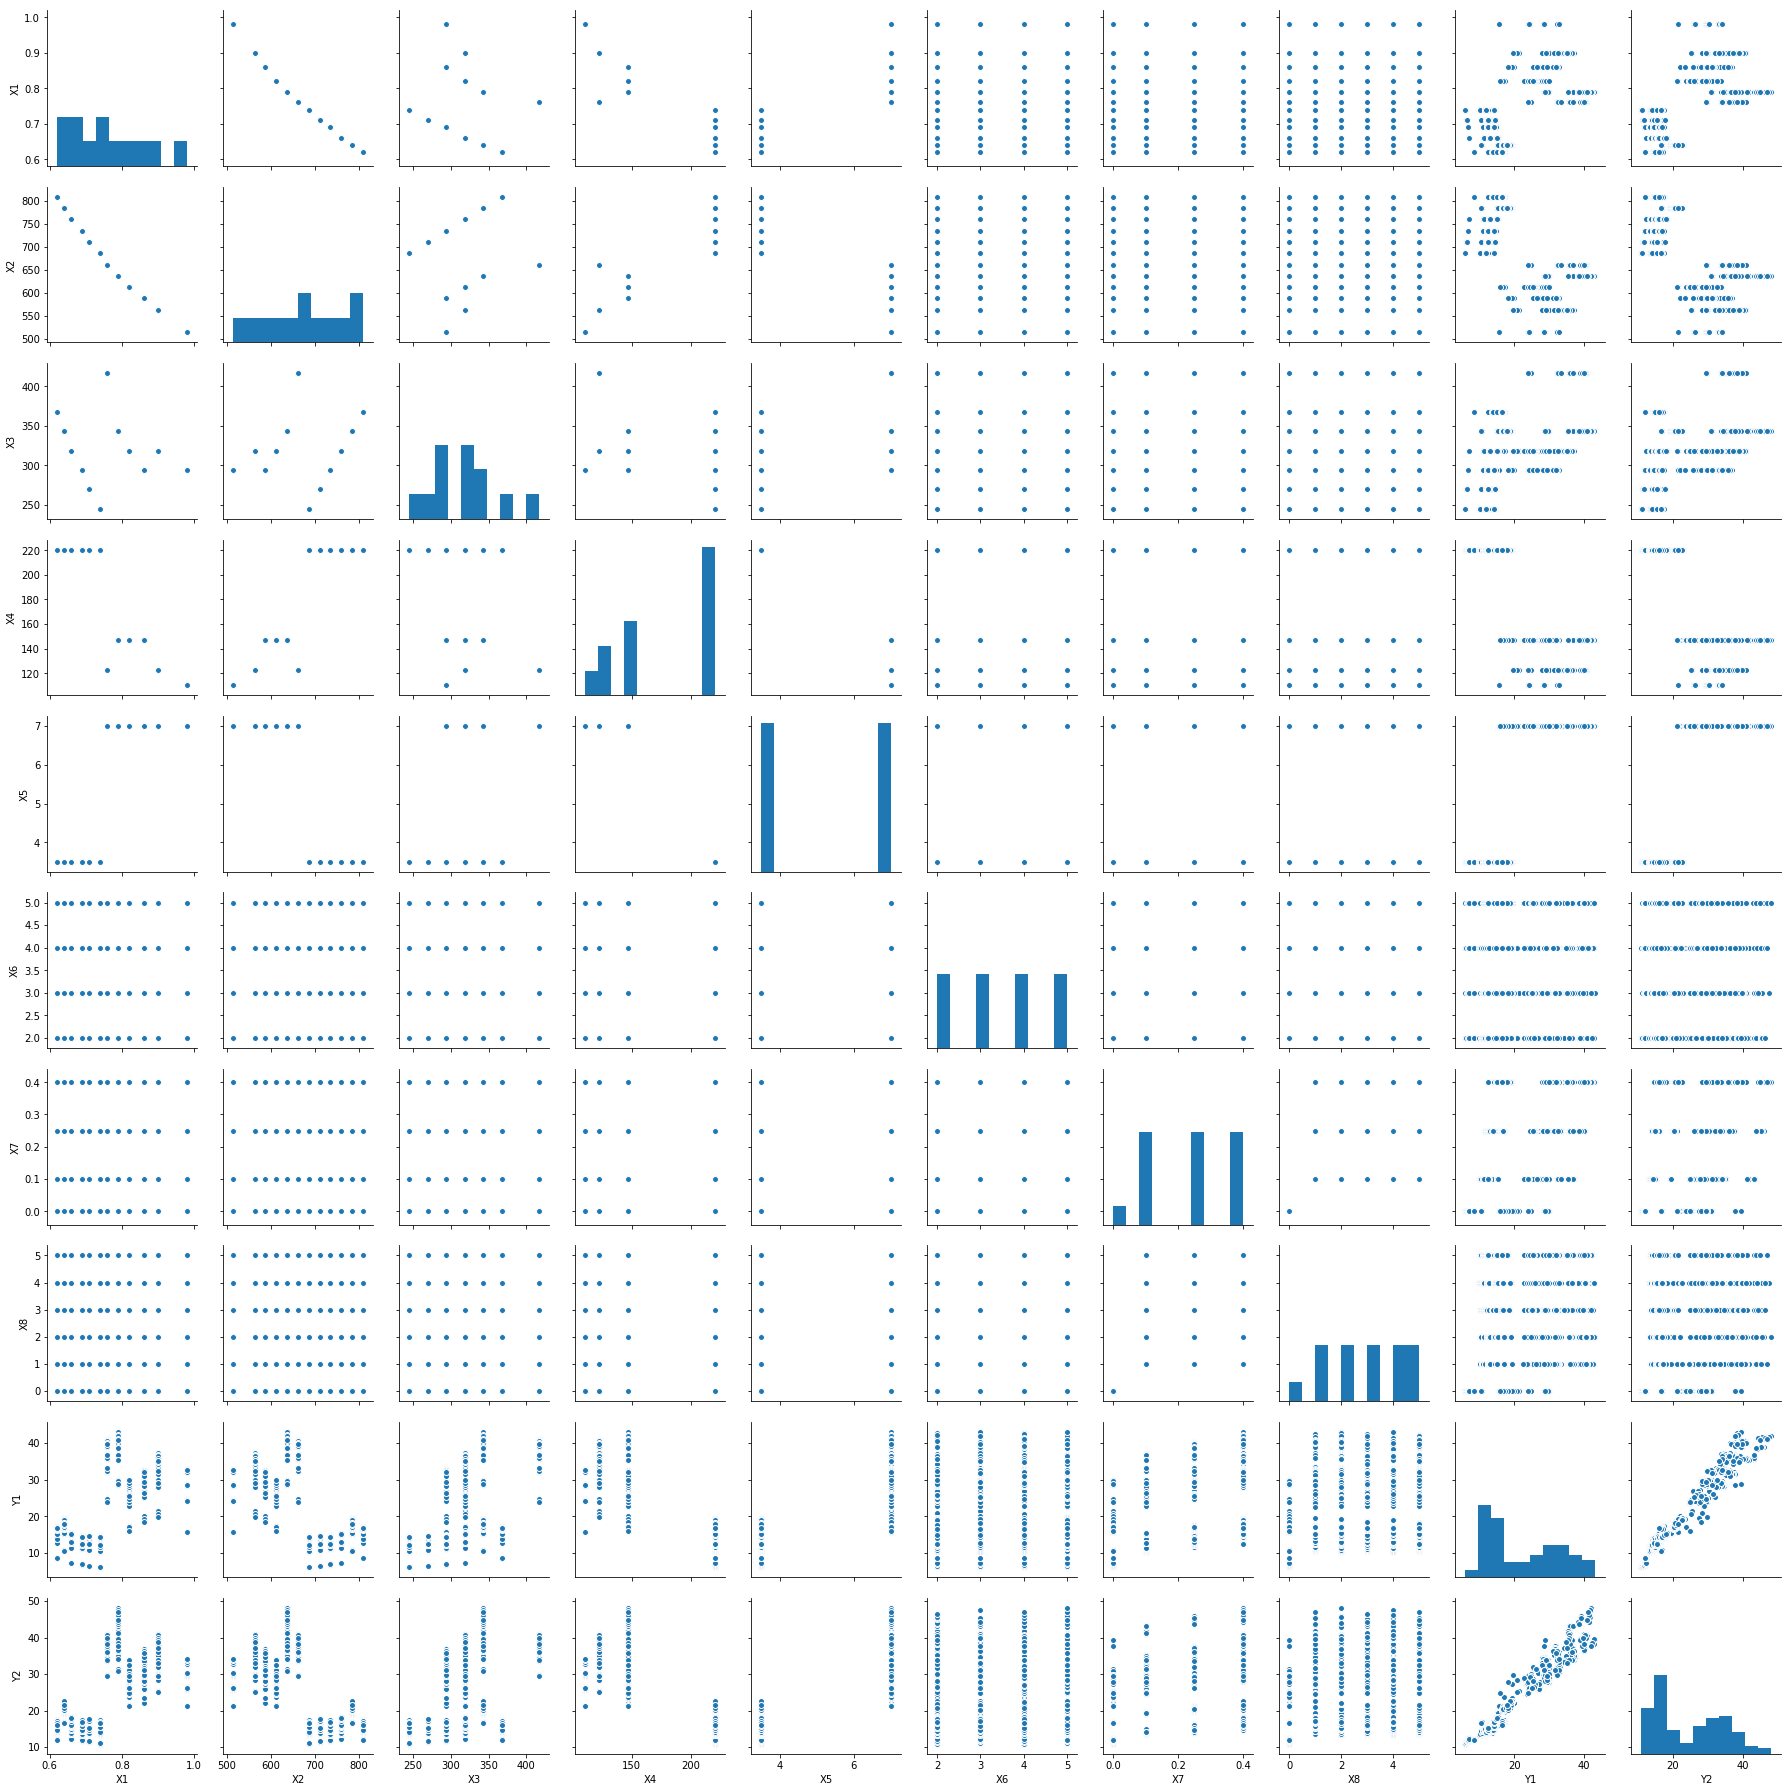

In [18]:
g = sns.pairplot(df)
g

As I mentioned above, 'X6', 'X7', and 'X8' should be categorical. So, I convert them to categorical using astype command. 

In [19]:
df['X6'] = df['X6'].astype('category')
df['X7'] = df['X7'].astype('category')
df['X8'] = df['X8'].astype('category')


We can also replace these categories with some meaningful names. I got this info by looking at some information available about this data set.

In [20]:
df['X6'].replace(2,"North",inplace=True)
df['X6'].replace(3,"East",inplace=True)
df['X6'].replace(4,"South",inplace=True)
df['X6'].replace(5,"West",inplace=True)

df['X7'].replace(0.00,"0%",inplace=True)
df['X7'].replace(0.10,"10%",inplace=True)
df['X7'].replace(0.25,"25%",inplace=True)
df['X7'].replace(0.40,"40%",inplace=True)

df['X8'].replace(0,"Unknown",inplace=True)
df['X8'].replace(1,"Uniform",inplace=True)
df['X8'].replace(2,"North",inplace=True)
df['X8'].replace(3,"East",inplace=True)
df['X8'].replace(4,"South",inplace=True)
df['X8'].replace(5,"West",inplace=True)

Now let's look at how many observation for each category we have.

In [21]:
df['X6'].value_counts()

East     192
West     192
South    192
North    192
Name: X6, dtype: int64

In [22]:
df['X7'].value_counts()

25%    240
10%    240
40%    240
0%      48
Name: X7, dtype: int64

In [23]:
df['X8'].value_counts()

East       144
West       144
South      144
Uniform    144
North      144
Unknown     48
Name: X8, dtype: int64

Now, we can start to build a regression model. I will use two methods. 1) ols from
statsmodel and 2) LinearRegression from sklearn. Since, we have some categorical attributes, we need to either convert them to dummy variables or use 'C' before variable name to show that they are categorical variables. In this exercise, I will explore both approaches.

### Run regression with categorical variable directly

Before building a model, I split the data into train and test. I will train part to fit a model, then I will use the test part to evaluate how good the model is.

In [27]:
train, test = train_test_split(df,test_size=0.3)


In [28]:
lm = smf.ols('Y1 ~ X1 + X2 + X3 + X4 + X5 + C(X6) + C(X7) + C(X8)', data = train).fit()

In [29]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Y1   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     453.7
Date:                Sun, 16 Dec 2018   Prob (F-statistic):          1.85e-281
Time:                        21:33:52   Log-Likelihood:                -1310.8
No. Observations:                 537   AIC:                             2652.
Df Residuals:                     522   BIC:                             2716.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           69.9363     17.462      4.005      0.000      35.632     104.240
C(X6)[T.North]      -0.4708      0.348     -1.353      0.177      -1.154       0.213
C(X6)[T.South]      -0.3240      0.340     -0.953      0.341      -0.992       0.344
C(X6)[T.West]       -0.5383      0.345     -1.560      0.119      -1.216       0.139
C(X7)[T.10%]        16.9351      4.367      3.878      0.000       8.356      25.514
C(X7)[T.25%]        19.6133      4.370      4.488      0.000      11.029      28.198
C(X7)[T.40%]        22.2420      4.370      5.089      0.000      13.656      30.828
C(X8)[T.North]       0.5642      0.387      1.460      0.145      -0.195       1.324
C(X8)[T.South]       0.3779      0.391      0.967      0.334      -0.390       1.146
C(X8)[T.Uniform]     0.9631      0.398      2.421      0.016       0.182       1.745
C(X8)[T.Unknown]    11.1459      4.392      2.538      0.011       2.518      19.773
C(X8)[T.West]        0.2595      0.400      0.649      0.516      -0.526       1.045
X1                 -63.7332     11.843     -5.381      0.000     -86.999     -40.467
X2                  -0.0631      0.015     -4.106      0.000      -0.093      -0.033
X3                   0.0388      0.004      8.821      0.000       0.030       0.047
X4                  -0.0510      0.009     -5.937      0.000      -0.068      -0.034
X5                   3.9854      0.385     10.342      0.000       3.228       4.742
==============================================================================
Omnibus:                       19.018   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.436
Skew:                           0.304   Prob(JB):                     1.10e-06
Kurtosis:                       3.926   Cond. No.                     7.13e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.23e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Now let's do prediction.

In [37]:
forecast = lm.predict(test)

In [38]:
d = {'actual': test['Y1'], 'forecast': forecast}
df2 = pd.DataFrame(data=d)

In [39]:
df2.head()

,actual,forecast
48,24.58,26.151952
454,36.81,37.274297
144,24.28,25.188831
567,15.23,17.718134
208,36.86,29.980012


Now we can calculate root mean square error.

In [25]:
RMSE = np.sqrt(np.mean((df2['actual']-df2['forecast'])**2))
RMSE

2.970024503627821

I plot actual and prediction to see how good my is. (visually)

In [41]:
df2['x']=np.arange(0,df2.shape[0])

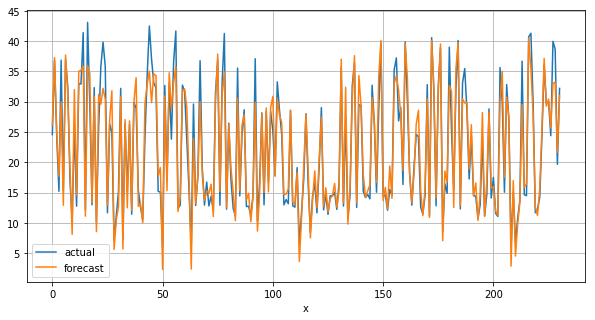

In [43]:
df2.plot(x='x', y=['actual', 'forecast'], figsize=(10,5), grid=True)

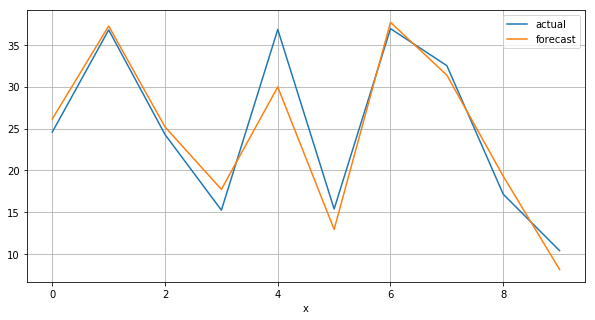

In [44]:
df2[:10].plot(x='x', y=['actual', 'forecast'], figsize=(10,5), grid=True)

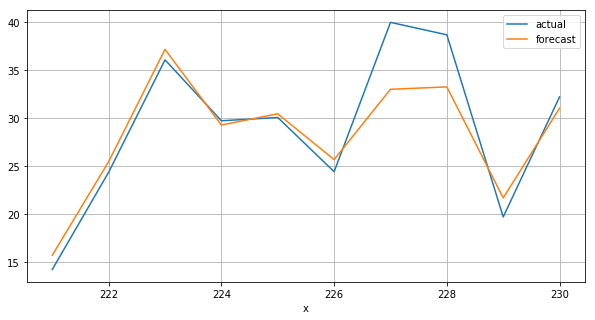

In [45]:
df2[-10:].plot(x='x', y=['actual', 'forecast'], figsize=(10,5), grid=True)

### Now Let's use Y2 (Cooling Load) as a response variable

In [46]:
lm2 = smf.ols('Y2 ~ X1 + X2 + X3 + X4 + X5 + C(X6) + C(X7) + C(X8)', data = train).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Y2   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     315.8
Date:                Sun, 16 Dec 2018   Prob (F-statistic):          3.62e-244
Time:                        21:47:32   Log-Likelihood:                -1368.5
No. Observations:                 537   AIC:                             2767.
Df Residuals:                     522   BIC:                             2831.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           77.1402     19.443      3.968      0.000      38.944     115.336
C(X6)[T.North]      -0.1791      0.387     -0.462      0.644      -0.940       0.582
C(X6)[T.South]      -0.0268      0.378     -0.071      0.944      -0.770       0.717
C(X6)[T.West]        0.3771      0.384      0.982      0.327      -0.378       1.132
C(X7)[T.10%]        18.3377      4.863      3.771      0.000       8.785      27.890
C(X7)[T.25%]        20.5556      4.866      4.225      0.000      10.997      30.114
C(X7)[T.40%]        22.4744      4.866      4.618      0.000      12.915      32.034
C(X8)[T.North]       0.8320      0.430      1.933      0.054      -0.013       1.677
C(X8)[T.South]       0.6716      0.435      1.544      0.123      -0.183       1.526
C(X8)[T.Uniform]     1.2048      0.443      2.720      0.007       0.334       2.075
C(X8)[T.Unknown]    15.7723      4.890      3.225      0.001       6.166      25.379
C(X8)[T.West]        0.2972      0.445      0.668      0.504      -0.577       1.171
X1                 -68.0607     13.187     -5.161      0.000     -93.966     -42.155
X2                  -0.0642      0.017     -3.753      0.000      -0.098      -0.031
X3                   0.0236      0.005      4.812      0.000       0.014       0.033
X4                  -0.0439      0.010     -4.593      0.000      -0.063      -0.025
X5                   4.2098      0.429      9.812      0.000       3.367       5.053
==============================================================================
Omnibus:                       80.393   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.458
Skew:                           0.827   Prob(JB):                     1.59e-37
Kurtosis:                       5.200   Cond. No.                     7.13e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.23e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [47]:
forecast2 = lm2.predict(test)
d2 = {'actual': test['Y2'], 'forecast': forecast}
df22 = pd.DataFrame(data=d2)
RMSE2 = np.sqrt(np.mean((df22['actual']-df22['forecast'])**2))
RMSE2


4.1660595653373065

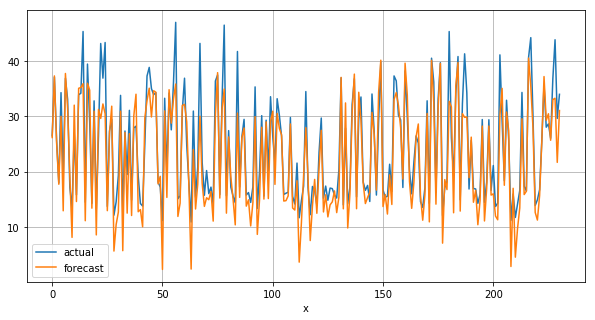

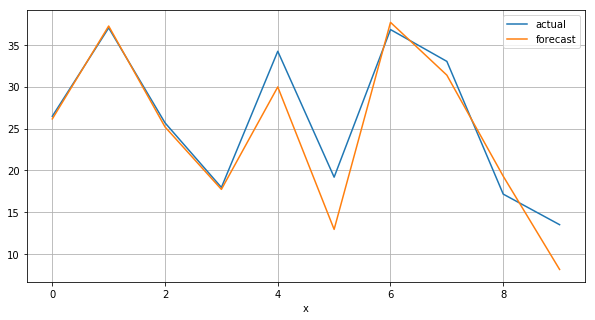

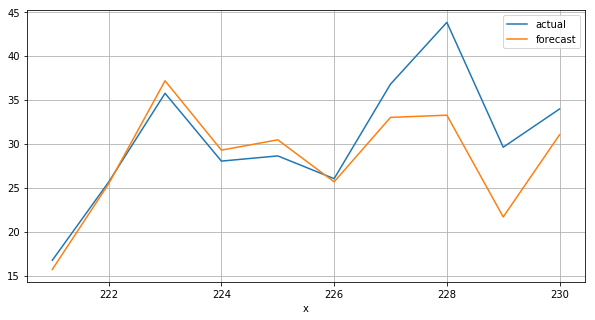

In [48]:
df22['x']=np.arange(0,df22.shape[0])
df22.plot(x='x', y=['actual', 'forecast'], figsize=(10,5), grid=True)
df22[:10].plot(x='x', y=['actual', 'forecast'], figsize=(10,5), grid=True)
df22[-10:].plot(x='x', y=['actual', 'forecast'], figsize=(10,5), grid=True)

## Another way to deal with categorical data by creating dummy variables

In [49]:
df = pd.read_excel('Energy.xlsx')

In [50]:
df['X8'].unique()

array([0, 1, 2, 3, 4, 5])

In [51]:
df['X6'] = df['X6'].replace({2: 'North', 3: 'East', 4: 'South', 5:'West'})
df['X7'] = df['X7'].replace({0.00: '0%', 0.10: '10%', 0.25: '25%', 0.40:'40%'})
df['X8'] = df['X8'].replace({0: 'Unknown', 1: 'Uniform', 2: 'North', 3:'East', 4:'South', 5:'West'})

In [52]:
df['X6'].unique()

array(['North', 'East', 'South', 'West'], dtype=object)

In [53]:
df = pd.get_dummies(df, columns=['X6','X7','X8'])

In [54]:
df.head()

,X1,X2,X3,X4,X5,Y1,Y2,X6_East,X6_North,X6_South,...,X7_0%,X7_10%,X7_25%,X7_40%,X8_East,X8_North,X8_South,X8_Uniform,X8_Unknown,X8_West
0,0.98,514.5,294.0,110.25,7.0,15.55,21.33,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0.98,514.5,294.0,110.25,7.0,15.55,21.33,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0.98,514.5,294.0,110.25,7.0,15.55,21.33,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0.98,514.5,294.0,110.25,7.0,15.55,21.33,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0.90,563.5,318.5,122.50,7.0,20.84,28.28,0,1,0,...,1,0,0,0,0,0,0,0,1,0


### Split data into train and test

In [55]:
X = df.drop(['Y1','Y2'], axis=1)
y = df[['Y1']] # later I will repeat for Y2

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Train a model

In [57]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [67]:
regression_model.coef_[0][0]

-66.56118656922683

 Since LinearRegression() method from sklearn does not have
summary command like stats model, we need to print the coefficients manually.

In [58]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for X1 is -66.56118656922668
The coefficient for X2 is -0.06551501312873798
The coefficient for X3 is 0.0354669969164082
The coefficient for X4 is -0.050491004988592374
The coefficient for X5 is 4.095916954431275
The coefficient for X6_East is 0.05439877841960567
The coefficient for X6_North is -0.03777332314024512
The coefficient for X6_South is -0.05225888915413095
The coefficient for X6_West is 0.03563343387468808
The coefficient for X7_0% is -3.371622416797361
The coefficient for X7_10% is -1.2618120567563673
The coefficient for X7_25% is 0.8200201293357042
The coefficient for X7_40% is 3.813414344217938
The coefficient for X8_East is 0.3414057508968357
The coefficient for X8_North is 0.8417886579550061
The coefficient for X8_South is 0.6641745818702924
The coefficient for X8_Uniform is 0.8387421167489592
The coefficient for X8_Unknown is -3.3716224167973627
The coefficient for X8_West is 0.685511309326282


In [59]:
intercept = regression_model.intercept_[0]

print("The intercept for our model is {}".format(intercept))

The intercept for our model is 92.04644652013238


## Calculating R^2

In [60]:
regression_model.score(X_train, y_train)

0.9304200594655133

In [61]:
y_predict = regression_model.predict(X_test)

regression_model_mse = mean_squared_error(y_predict, y_test)

print("Mean square error is {}".format(regression_model_mse))
print("Root mean square error is {}".format(math.sqrt(regression_model_mse)))

Mean square error is 9.887999298004232
Root mean square error is 3.1445189295032447


Now, we repeat again for Y2.

In [64]:
X = df.drop(['Y1','Y2'], axis=1)
y = df[['Y2']] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for X1 is -73.75777855857822
The coefficient for X2 is -0.07057015878927146
The coefficient for X3 is 0.022186903583462255
The coefficient for X4 is -0.04637853114871007
The coefficient for X5 is 4.175149391312566
The coefficient for X6_East is -0.37502098113888316
The coefficient for X6_North is -0.10894161697506691
The coefficient for X6_South is 0.07871160702268909
The coefficient for X6_West is 0.4052509910911705
The coefficient for X7_0% is -2.1790775777391582
The coefficient for X7_10% is -1.1505387620219358
The coefficient for X7_25% is 0.5107700205294087
The coefficient for X7_40% is 2.818846319231588
The coefficient for X8_East is -0.015959531588995577
The coefficient for X8_North is 0.582624685179016
The coefficient for X8_South is 0.4014289286732133
The coefficient for X8_Uniform is 0.7841003433722225
The coefficient for X8_Unknown is -2.179077577739159
The coefficient for X8_West is 0.42688315210371686


In [65]:
y_predict = regression_model.predict(X_test)

regression_model_mse = mean_squared_error(y_predict, y_test)

print("Mean square error is {}".format(regression_model_mse))
print("Root mean square error is {}".format(math.sqrt(regression_model_mse)))

Mean square error is 13.347773929097428
Root mean square error is 3.653460541609479


### Conclusion: Based on the RMSE value,the model for Y1 performs better.